# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import utils

import osmnx as ox
import networkx as nx
import geopandas as gpd
import shapely
import shapely.geometry
import folium
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Get data

In [4]:
network_type = "drive"
distance = 70000
locations = [
    (11.14674,60.31262),
    (11.47577,60.11964),
    (11.166858,60.13423),
    (11.561687,59.879044),
    (10.987775,59.932076),
    (10.880784,60.042152),
    (10.831094,59.930733),
    (10.758744,59.917),
    (10.741926,59.93917),
    (10.853331,59.71566),
    (10.725881,59.659687),
    (10.806946,59.833073),
    (10.439887,59.830055),
    (10.509723,59.89813),
    (10.687367,59.939663),
    (10.806364,59.893173),
    (10.884091,59.960304),
    (11.03928,59.997875),
    (10.585751,59.917873)
]

graph = ox.graph_from_point((59.978023, 11.041620), dist=distance, network_type=network_type)
graph = ox.project_graph(graph, to_crs=f"EPSG:326{33}")


In [5]:
trip_times = [12, 25]

iso_colors = ox.plot.get_colors(len(trip_times), cmap="plasma", start=0.3, return_hex=True)
center_nodes = []
for location in locations:
    lon, lat = location
    x, y = utils.geographic_to_utm(lon, lat)
    center_nodes.append(ox.distance.nearest_nodes(graph, x, y))

In [6]:
speeds_normal = {
    30: 26.9,
    40: 45.4,
    50: 67.6,
    60: 85.8,
    70: 91.8,
    80: 104.2,
    90: 104.2, # custom
    100: 120.0,
    110: 120.0, # custom
    120: 136.9
}
INTERSECTION_PENALTY = 10

# Adjust the weights of the edges in the graph based on the average speeds and intersection penalty
for u, v, data in graph.edges(data=True):
    # Use average speeds if available
    if "maxspeed" in data:
        # Take the min of the maxspeed list (in case it's a list)
        if isinstance(data["maxspeed"], list):
            speed_limits = [speeds_normal.get(int(s), int(s)) for s in data["maxspeed"]]
            speed_limit = sum(speed_limits) / len(speed_limits)
        else:
            speed_limit = speeds_normal.get(int(data["maxspeed"]), int(data["maxspeed"]))
        
        # Use average speed if available, else use speed limit
        avg_speed = speed_limit * 0.65
    else:
        avg_speed = 50  # Default speed if not provided
    
    # Calculate time = distance/speed and assign it as the new weight
    # Speeds are in km/h, so converting them to m/min
    data["time"] = data["length"] / (avg_speed * 1000/60)

    # Add intersection penalty if the road segment has an intersection
    if "junction" in graph.nodes[u] or "highway" in graph.nodes[u] and graph.nodes[u]["highway"] == "traffic_signals":
        data["time"] += INTERSECTION_PENALTY / 60
    if "junction" in graph.nodes[v] or "highway" in graph.nodes[v] and graph.nodes[v]["highway"] == "traffic_signals":
        data["time"] += INTERSECTION_PENALTY / 60


In [7]:
def make_iso_polys(G, center_node, trip_time, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []

    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

    node_points = [shapely.geometry.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", shapely.geometry.LineString([f, t]))
        edge_lines.append(edge_lookup)

    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union

    if infill:
        new_iso = shapely.geometry.Polygon(new_iso.exterior)
    isochrone_polys.append(new_iso)

    return isochrone_polys


# make the isochrone polygons
all_isochrone_polys = []
all_isochrone_colors = []
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for center_node in center_nodes:
        isochrone_polys = make_iso_polys(graph, center_node, trip_time, edge_buff=25, node_buff=0, infill=True)
        all_isochrone_polys.extend(isochrone_polys)
        all_isochrone_colors.append(color)


# Plot

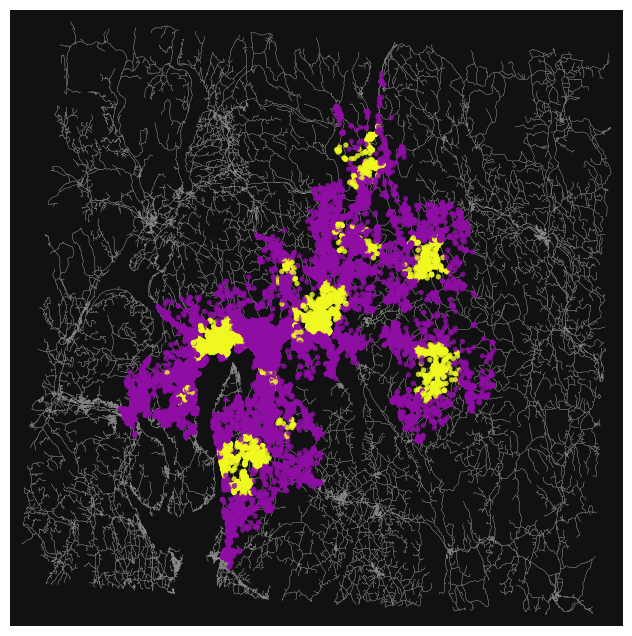

In [8]:
# plot nodes over empty canvas
node_colors = {}
for center_node in center_nodes:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(graph, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            node_colors[node] = color

nc = [node_colors.get(node, "none") for node in graph.nodes()]
ns = [15 if node in node_colors else 0 for node in graph.nodes()]

fig, ax = ox.plot_graph(
    graph,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)


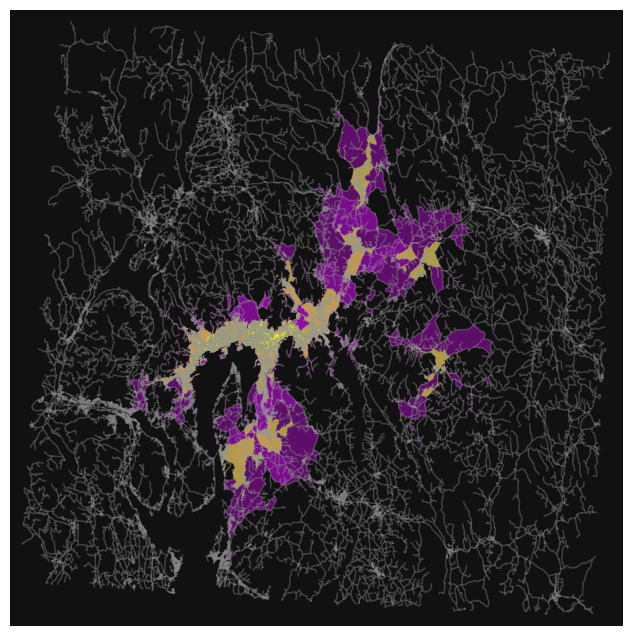

In [9]:
# plot isochrones as colored polygon patches over empty canvas
fig, ax = ox.plot_graph(
    graph, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for color, polygon in zip(all_isochrone_colors, all_isochrone_polys):
    gdf_single = gpd.GeoDataFrame(geometry=[polygon])
    gdf_single.plot(ax=ax, color=color, ec="none", alpha=0.6, zorder=-1)

plt.show()


In [10]:
# plot isochrones as colored polygon patches over map
m = folium.Map(location=[59.978023, 11.041620], zoom_start=12)

# Function to add isochrones to the map
def add_isochrones_to_map(map_obj, isochrone_polys, isochrone_colors):
    for color, geom in zip(isochrone_colors, isochrone_polys):
        geo_json = gpd.GeoDataFrame(geometry=[geom], crs=f"EPSG:326{33}")
        folium.GeoJson(
            geo_json,
            style_function=lambda feature, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 1,
                'fillOpacity': 1.0,
            }
        ).add_to(map_obj)


# Call the function to add the isochrones to the map
add_isochrones_to_map(m, all_isochrone_polys, all_isochrone_colors)


akershus_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2019_akershus_polygon_epsg4326.geojson"))
oslo_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2019_oslo_polygon_epsg4326.geojson"))
urban_settlements_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2021_urban_settlements_polygon_epsg4326.geojson"))

combined_gdf = gpd.GeoDataFrame(pd.concat([akershus_gdf, oslo_gdf], ignore_index=True))

urban_clipped_akershus_oslo = gpd.overlay(urban_settlements_gdf, combined_gdf, how='intersection')

akershus_gdf['dissolve_field'] = 'Region'
oslo_gdf['dissolve_field'] = 'Region'
combined_gdf = pd.concat([akershus_gdf, oslo_gdf], ignore_index=True)
dissolved_gdf = combined_gdf.dissolve(by='dissolve_field')

oslo_akershus_geojson = dissolved_gdf.to_json()
urban_clipped_geojson = urban_clipped_akershus_oslo.to_json()

palette = sns.color_palette("husl", 4)
region_color = palette.as_hex()[1]
urban_color = palette.as_hex()[0]

folium.GeoJson(
    oslo_akershus_geojson,
    name='Oslo og Akershus',
    style_function=lambda x: {'fillColor': region_color, 'color': region_color}
).add_to(m)

folium.GeoJson(
    urban_clipped_geojson,
    name='Tettbygd strøk',
    style_function=lambda x: {'fillColor': urban_color, 'color': urban_color}
).add_to(m)

folium.LayerControl().add_to(m)


# Show the map
m.save(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "isochrone_map_polygons.html"))


In [13]:
# Initialize folium map
m = folium.Map(location=location_point, zoom_start=12, tiles='cartodb positron')

# Add roads to the map
ox.folium.plot_graph_folium(G, graph_map=m, edge_color="white", edge_width=0.2)

# Add isochrones as markers
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [(data["y"], data["x"]) for node, data in G.nodes(data=True) if node in subgraph.nodes()]
    for point in node_points:
        folium.CircleMarker(location=point, radius=4, color=color, fill=True, fill_opacity=0.6).add_to(m)

m

NameError: name 'G' is not defined

In [18]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time

longitude_shift = 0.1 # to centralize map

# plot isochrones as colored polygon patches over map
m = folium.Map(location=[59.978023 + longitude_shift, 11.041620], zoom_start=9)

# Function to add isochrones to the map
def add_isochrones_to_map(map_obj, isochrone_polys, isochrone_colors):
    for color, geom in zip(isochrone_colors, isochrone_polys):
        geo_json = gpd.GeoDataFrame(geometry=[geom], crs=f"EPSG:326{33}")
        folium.GeoJson(
            geo_json,
            style_function=lambda feature, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 1,
                'fillOpacity': 1.0,
            }
        ).add_to(map_obj)


# Call the function to add the isochrones to the map
add_isochrones_to_map(m, all_isochrone_polys, all_isochrone_colors)


akershus_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2019_akershus_polygon_epsg4326.geojson"))
oslo_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2019_oslo_polygon_epsg4326.geojson"))
urban_settlements_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2021_urban_settlements_polygon_epsg4326.geojson"))

combined_gdf = gpd.GeoDataFrame(pd.concat([akershus_gdf, oslo_gdf], ignore_index=True))

urban_clipped_akershus_oslo = gpd.overlay(urban_settlements_gdf, combined_gdf, how='intersection')

akershus_gdf['dissolve_field'] = 'Region'
oslo_gdf['dissolve_field'] = 'Region'
combined_gdf = pd.concat([akershus_gdf, oslo_gdf], ignore_index=True)
dissolved_gdf = combined_gdf.dissolve(by='dissolve_field')

oslo_akershus_geojson = dissolved_gdf.to_json()
urban_clipped_geojson = urban_clipped_akershus_oslo.to_json()

palette = sns.color_palette("husl", 4)
region_color = palette.as_hex()[1]
urban_color = palette.as_hex()[0]

folium.GeoJson(
    oslo_akershus_geojson,
    name='Oslo og Akershus',
    style_function=lambda x: {'fillColor': region_color, 'color': region_color}
).add_to(m)

"""
folium.GeoJson(
    urban_clipped_geojson,
    name='Tettbygd strøk',
    style_function=lambda x: {'fillColor': urban_color, 'color': urban_color}
).add_to(m)
"""

folium.LayerControl().add_to(m)

m.save('./maps/isochrone_map_polygons.html')

# Set up the Selenium driver
service = Service(executable_path=r'C:\Users\torju\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe')
driver = webdriver.Chrome(service=service)

# Define the path to the map.html file
map_html_path = r'C:\Programming\GitHub projects\Data-Processing\source\analysis\maps\isochrone_map_polygons.html'

# Open the map in the browser
driver.get(map_html_path)

# Give the map time to load
time.sleep(20)

# Set the size of the window to capture the entire map
driver.set_window_size(800, 1600)  # You can adjust this as needed

# Take a screenshot and save it
driver.save_screenshot('./maps/isochrone_map_polygons.png')

# Close the driver
driver.quit()
